In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

### Loading the dataset

In [3]:
df = pd.read_csv('cluster_data1.csv')
df.head()

,X1,X2,X3,X4
0,6.7,3.0,5.0,1.7
1,6.3,2.9,5.6,1.8
2,5.6,3.0,4.5,1.5
3,7.6,3.0,6.6,2.1
4,6.0,3.4,4.5,1.6


In [4]:
df.columns

Index(['X1', 'X2', 'X3', 'X4'], dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      150 non-null    float64
 1   X2      150 non-null    float64
 2   X3      150 non-null    float64
 3   X4      150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB


In [6]:
df.isnull().sum()

X1    0
X2    0
X3    0
X4    0
dtype: int64

### Checking the distribution and characteristics of the dataset it gives an overview of the key metrics of numerical columns in the dataset.

In [8]:
print("\nDescriptive statistics")
df.describe()


Descriptive statistics


,X1,X2,X3,X4
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


There are 150 data points in each column with no missing values. 
- Mean and standard deviation differ in each feature which tells that all the features are on different scales. Mean of X1 is much higher than X4 and Standard Deviation of X3 is large spread than X2.
- The range for X1 is from 4.3 to 7.9 where as X4 range is from 0.1 to 2.5. 
### K-means is very sensitive to scales as it uses distance (euclidean distance) calculation to assign data points to the clusters. If you see here in X1 and X4 has larger range. This will impact the distance calculation and will lead to biased output. To avoid this we need to standardize all features to same scale which will have mean of 0 and standard deviation of 1. Doing this will help in treating all features equally in distance calculations 
- Z-score Standardization formula = X - Mean / Standard Deviation and scale is [-3,3]


In [10]:
def standardize_cluster_data(df):
    for column in df.columns:
        mean_val = df[column].mean()
        std_dev = df[column].std()
        df[column] = (df[column] - mean_val) / std_dev
    return df

In [11]:
df_standardized = standardize_cluster_data(df)
df_standardized

,X1,X2,X3,X4
0,1.034539,-0.124540,0.703536,0.656917
1,0.551486,-0.355171,1.043591,0.787951
2,-0.293857,-0.124540,0.420157,0.394849
3,2.121409,-0.124540,1.610349,1.181053
4,0.189196,0.797981,0.420157,0.525883
...,...,...,...,...
145,-0.535384,1.951133,-1.393470,-1.046525
146,-0.656147,1.489872,-1.280118,-1.308593
147,0.309959,-1.047062,1.043591,0.263815
148,-0.173094,1.720502,-1.166767,-1.177559


In [12]:
df_standardized.describe()

,X1,X2,X3,X4
count,1.500000e+02,1.500000e+02,1.500000e+02,1.500000e+02
mean,-4.381680e-16,-6.587323e-16,-2.368476e-16,-1.539509e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.863780e+00,-2.430844e+00,-1.563497e+00,-1.439627e+00
25%,-8.976739e-01,-5.858010e-01,-1.223442e+00,-1.177559e+00
50%,-5.233076e-02,-1.245404e-01,3.351431e-01,1.327811e-01
75%,6.722490e-01,5.673506e-01,7.602119e-01,7.879511e-01
max,2.483699e+00,3.104284e+00,1.780377e+00,1.705189e+00


As seen above the data has been standardized mean to 0 and standard deviation to 1

### PART1: Implementation of K-means

### Step 1: Choose the number of clusters k

In [16]:
df_for_clustering = df_standardized

In [17]:
k = 3

### Step 2: Select k random points from the data as centroids

In [19]:
def init_centroid(df, k, random_seed=123):
    np.random.seed(random_seed)
    centroids = df.sample(n=k, random_state=random_seed).to_numpy()
    print(f"\nCentroids shape: {centroids.shape}")
    return centroids

#### Since we are using k =3, this function will randomly select three centroids. Initial centroids are selected from the dataset of each feature X1,X2,X3,X4 based on these points initial clusters are formed. Using a fixed random seed (random_seed=123) ensures that every run of the code returns the same initial centroids.

### Step 3: Calculate distance of all the data points from the centroids.

In [22]:
def cal_euclid_distance(df, centroids):
    distances = []
    data_points = df.to_numpy()
    for i in range(len(centroids)):
        centroid = centroids[i]
        distance = np.sqrt(((data_points - centroid) ** 2).sum(axis=1))
        distances.append(distance)
    return np.array(distances).T

#### Using Euclidean distance : d = square root of (x1 − x2)^2+(y1 − y2)^2. Euclidean distance is used since it basically measures the closeness between data points and centroids in multi-dimensional feature space. Euclidean distance plays an important role in the K-Means algorithm, wherein, in every iteration, the data points are assigned to the nearest centroid on the basis of minimum Euclidean distance with further updating of clusters. 

### Step 4: Assign all the points to the closest cluster centroid

In [25]:
def closest_centroid(distances):
    return np.argmin(distances, axis=1)

#### After calculating the euclidean distance between data points and centroids we assign each data point to the nearest or closest centroid to form a cluster by finding the minimum distance centroid

### Step 5: Recompute the centroids of newly formed clusters and print the new centroids

In [28]:
def recompute_centroids(df, clusters, k):
    new_centroids = []
    for i in range(k):
        cluster_points = df[clusters == i]
        new_centroid = cluster_points.mean(axis=0).to_numpy()
        new_centroids.append(new_centroid)
    return np.array(new_centroids)

#### After data points have been assigned to closest clusters we recalculate the centroids after each iteration based on the mean of the points in each cluster. Ideally, we recompute the centroids until stopping criteria. i.e. • Centroids of newly formed clusters do not change • Points remain in the same cluster • Maximum number of iterations is reached but since we have been given iteration = 4 so we will be doing it only for four iterations

In [29]:
def print_centroids(new_centroids, iteration=None):
    if iteration is None:
        title = "First Centroid:"
    else:
        title = f"Iteration {iteration} Centroids:"
    print(title)
    for i, centroid in enumerate(new_centroids):
        centroid_str = ', '.join([f"x{j+1}: {coord:.4f}" for j, coord in enumerate(centroid)])
        print(f"Centroid {i+1}: [{centroid_str}]")
    print("-" * 50)

#### Using this function to format and display the centroids at different iterations to keep track of how centroids are intialized and updated in k-means.

In [31]:
def display_cluster_info(clusters, k, iteration=None):
    if iteration is None:
        print("Before Iteration 1:")
    else:
        print(f"After Iteration {iteration}:")
    cluster_counts = np.bincount(clusters, minlength=k)
    for cluster_idx in range(k):
        print(f"Number of points in cluster {cluster_idx + 1}: {cluster_counts[cluster_idx]}")
    print(f"Cluster Assignments: {clusters[:10] + 1}...")
    print("-" * 50)

### Steps for visualization of intial centriods with data

In [35]:
def init_centroids_formation(df, centroids):
    plt.figure(figsize=(8, 6))
    plt.scatter(df['X1'], df['X2'], color='gray', marker='o', label='Data Points', alpha=0.7)
    plt.scatter(centroids[:, 0], centroids[:, 1], color='red', marker='o', s=50, edgecolor='black', label='Initial Centroids')
    plt.title('K-Means Initial Data with Initial Centroids', fontsize=14)
    plt.xlabel('X1', fontsize=12)
    plt.ylabel('X2', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

#### This function is used to visualize inital centroids along with data points for feature X1 vs X2 in a 2-D space. It helps us understand how the initial centroids are spread out among the data points before the k means clustering

### Function to visualize initial cluster formation before iteration 1 i.e. after centroids initialization.

In [37]:
def plot_initial_assignment(df, centroids, clusters):
    plt.figure(figsize=(8, 6))
    colors = ['r', '#008080', '#FFA500']
    for i in range(len(centroids)):
        cluster_points = df[clusters == i]
        plt.scatter(cluster_points['X1'], cluster_points['X2'], c=colors[i], label=f'Cluster {i+1}', alpha=0.7, marker='o')
    for i in range(len(centroids)):
        plt.scatter(centroids[i, 0], centroids[i, 1], s=100, c=colors[i], marker='X', edgecolor='black', label=f'Initial Centroid {i+1}')
    plt.title('K-Means Initial Cluster Assignment')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

### Step 6: Visualization of cluster formation using k-means

In [39]:
def clusters_formation(df, clusters, centroids, new_centroids, iteration):
    colors = ['r', '#008080', '#FFA500']
    plt.figure(figsize=(8, 6))
    for i in range(len(centroids)):
        cluster_points = df[clusters == i]
        plt.scatter(cluster_points['X1'], cluster_points['X2'], c=colors[i % len(colors)], label=f'Cluster {i+1}', alpha=0.7, marker='o')
    for i in range(len(centroids)):
        plt.scatter(centroids[i, 0], centroids[i, 1], s=100, c=colors[i % len(colors)], marker='X', edgecolor='black', label=f'Previous Centroid {i+1}')
    for i in range(len(new_centroids)):
        plt.scatter(new_centroids[i, 0], new_centroids[i, 1], s=100, c=colors[i % len(colors)], marker='o', edgecolor='black', label=f'New Centroid {i+1}')
    plt.title(f'K-Means Clustering: Iteration {iteration + 1}', fontsize=14, fontweight='bold')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

#### This function will clearly visualize each cluster with different colors on how centroids move from one iteration to another showing previous and new centroids in the clusters

### Step 8: Repeat steps 3, 4, 5, 6

In [42]:
def k_means_implementation(df, k, max_iters=25, random_seed=123, tolerance=1e-4):
    centroids = init_centroid(df, k, random_seed)
    print_centroids(centroids)  
    init_centroids_formation(df, centroids)
    distances = cal_euclid_distance(df, centroids)
    clusters = closest_centroid(distances)
    display_cluster_info(clusters, k)
    plot_initial_assignment(df, centroids, clusters)
    for iteration in range(max_iters):
        distances = cal_euclid_distance(df, centroids)
        clusters = closest_centroid(distances)
        new_centroids = recompute_centroids(df, clusters, k)
        display_cluster_info(clusters, k, iteration + 1)
        print_centroids(new_centroids, iteration + 1)
        if np.allclose(centroids, new_centroids, atol=tolerance):
            print(f"\nConvergence reached at iteration {iteration + 1}.")
            break
        clusters_formation(df, clusters, centroids, new_centroids, iteration)
        centroids = new_centroids
    return clusters, centroids

#### The k-means steps:
#### - Initial centroids are randomly taken from the data points.
#### - Euclidean distance is calculated
#### - Data points are assigned to the nearest centroids to form a cluster and it updates the centroids based on the data points in each cluster.
#### - Recompute the centroids by calculating the mean of the points in each cluster.
#### - Check for convergence, iteration stops if the centroids don't change.
#### - Each iteration's cluster formation and movement of centroids are visualized.


Centroids shape: (3, 4)
First Centroid:
Centroid 1: [x1: -0.7769, x2: 1.0286, x3: -1.2801, x4: -1.3086]
Centroid 2: [x1: -1.2600, x2: 0.7980, x3: -1.0534, x4: -1.3086]
Centroid 3: [x1: 1.6384, x2: 1.2592, x3: 1.3270, x4: 1.7052]
--------------------------------------------------


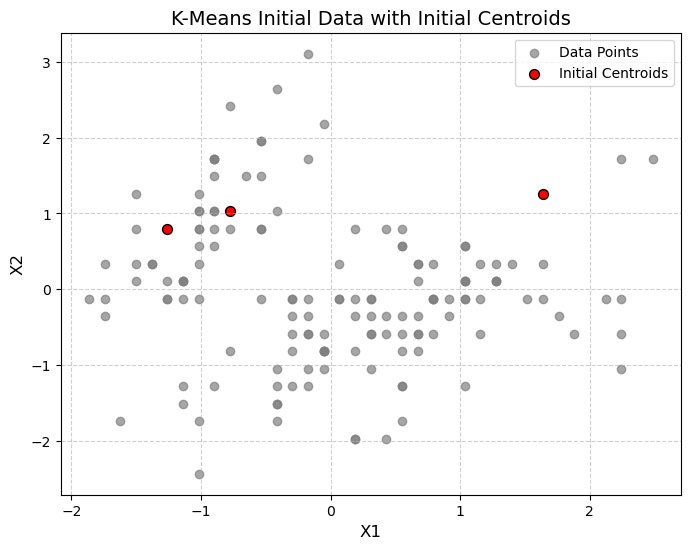

Before Iteration 1:
Number of points in cluster 1: 25
Number of points in cluster 2: 54
Number of points in cluster 3: 71
Cluster Assignments: [3 3 2 3 3 3 3 2 2 2]...
--------------------------------------------------


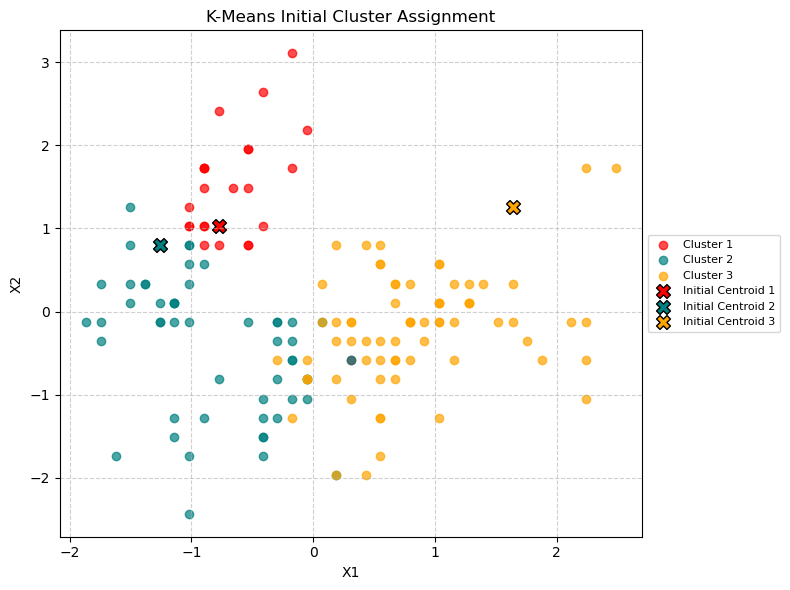

After Iteration 1:
Number of points in cluster 1: 25
Number of points in cluster 2: 54
Number of points in cluster 3: 71
Cluster Assignments: [3 3 2 3 3 3 3 2 2 2]...
--------------------------------------------------
Iteration 1 Centroids:
Centroid 1: [x1: -0.6368, x2: 1.4253, x3: -1.2280, x4: -1.1514]
Centroid 2: [x1: -0.8306, x2: -0.3936, x3: -0.5664, x4: -0.6049]
Centroid 3: [x1: 0.8559, x2: -0.2025, x3: 0.8632, x4: 0.8655]
--------------------------------------------------


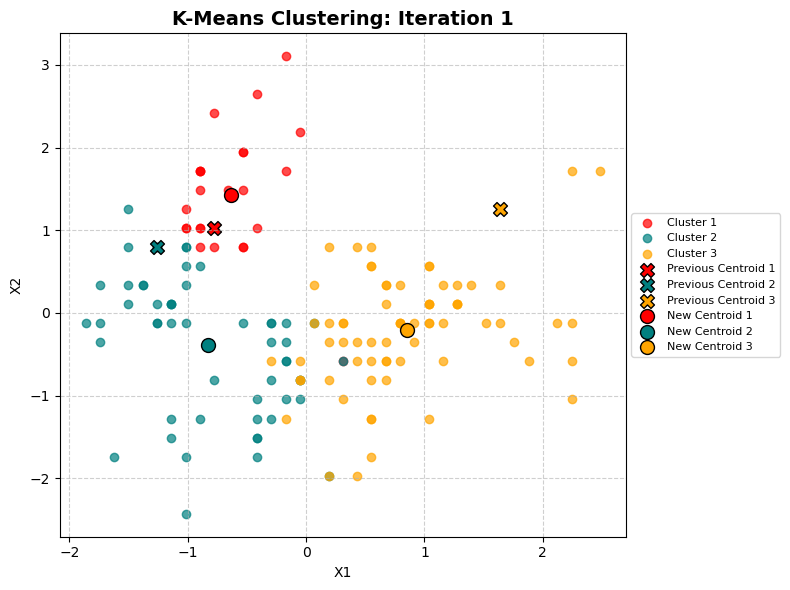

After Iteration 2:
Number of points in cluster 1: 36
Number of points in cluster 2: 38
Number of points in cluster 3: 76
Cluster Assignments: [3 3 3 3 3 3 3 2 2 1]...
--------------------------------------------------
Iteration 2 Centroids:
Centroid 1: [x1: -0.8708, x2: 1.2208, x3: -1.2943, x4: -1.2176]
Centroid 2: [x1: -0.7801, x2: -0.7254, x3: -0.4330, x4: -0.4914]
Centroid 3: [x1: 0.8025, x2: -0.2156, x3: 0.8296, x4: 0.8224]
--------------------------------------------------


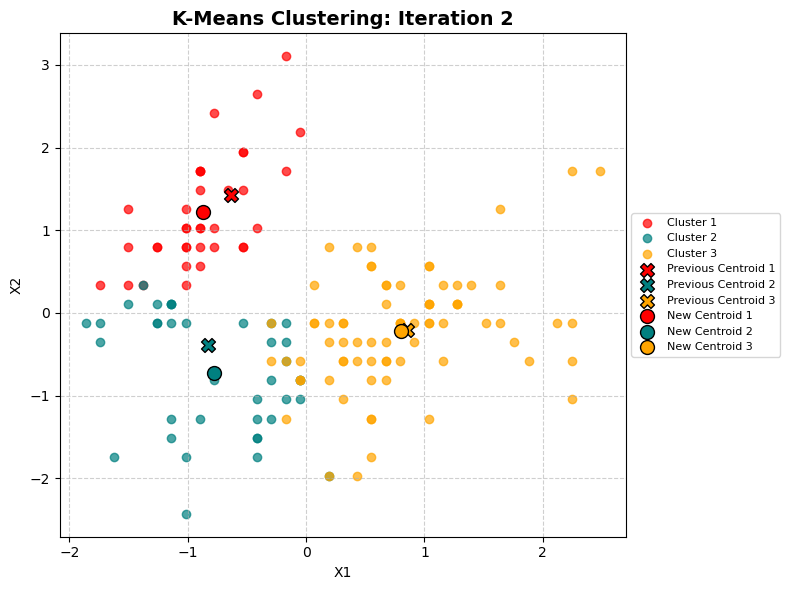

After Iteration 3:
Number of points in cluster 1: 46
Number of points in cluster 2: 29
Number of points in cluster 3: 75
Cluster Assignments: [3 3 3 3 3 3 3 2 2 1]...
--------------------------------------------------
Iteration 3 Centroids:
Centroid 1: [x1: -0.9764, x2: 0.9634, x3: -1.2986, x4: -1.2516]
Centroid 2: [x1: -0.5604, x2: -0.9834, x3: -0.0997, x4: -0.1654]
Centroid 3: [x1: 0.8156, x2: -0.2106, x3: 0.8350, x4: 0.8316]
--------------------------------------------------


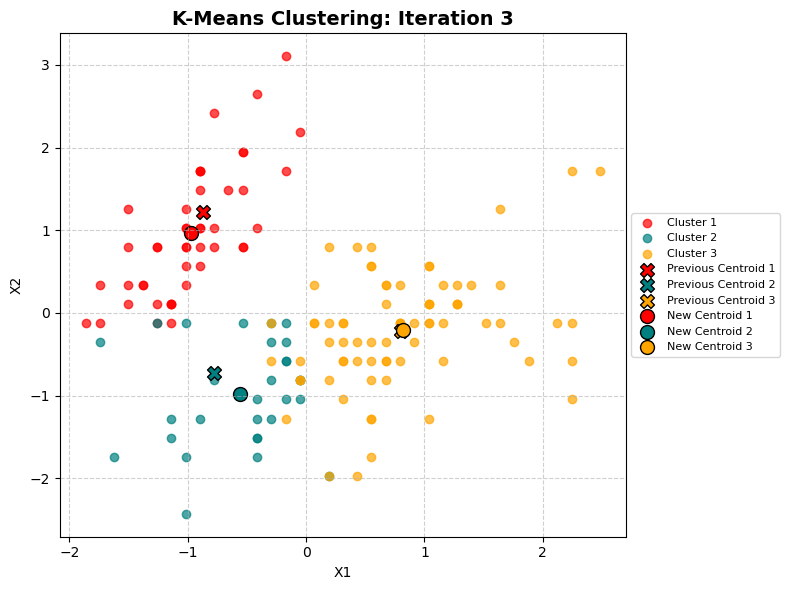

After Iteration 4:
Number of points in cluster 1: 49
Number of points in cluster 2: 31
Number of points in cluster 3: 70
Cluster Assignments: [3 3 2 3 3 3 3 1 1 1]...
--------------------------------------------------
Iteration 4 Centroids:
Centroid 1: [x1: -0.9987, x2: 0.8921, x3: -1.2986, x4: -1.2524]
Centroid 2: [x1: -0.3562, x2: -1.1066, x3: 0.0984, x4: 0.0144]
Centroid 3: [x1: 0.8568, x2: -0.1344, x3: 0.8655, x4: 0.8703]
--------------------------------------------------


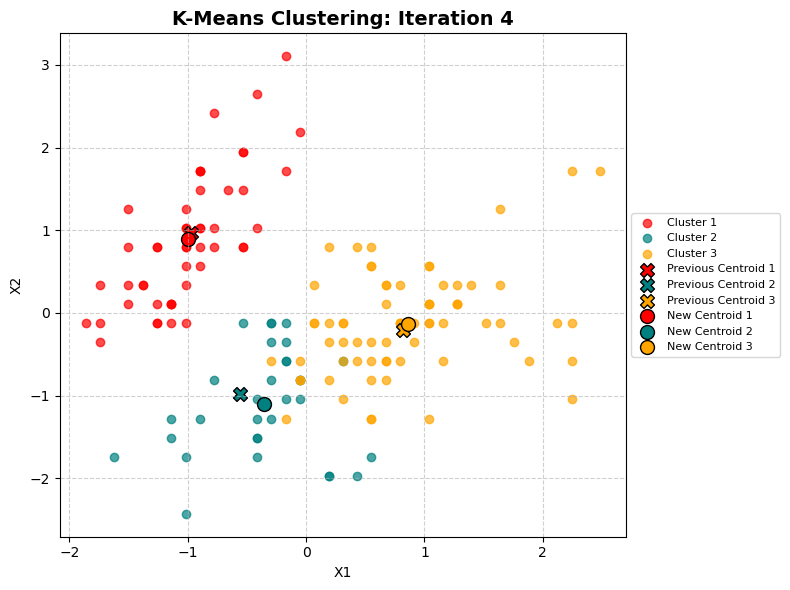

In [44]:
clusters, final_centroids = k_means_implementation(df_for_clustering, k, max_iters=4)

- Selected initial centroids (k=3):K-Means initiates by arbitrarily choosing three data points as starting centroids. Since each data point has 4 features, these centroids will be 4-dimensional; the coordinates of the centroid represent its position in that 4-dimensional feature space.
   [[-0.77691058  1.02861128 -1.28011819 -1.30859282]
   [-1.25996379  0.79798095 -1.05341485 -1.30859282]
   [ 1.63835547  1.25924161  1.32697021  1.70518904]] 

- The reason there are 4 values for each centroid is that each data point has 4 dimensions, or features. Centroids selected as points in that multi-dimensional space-so each centroid needs coordinates in all four dimensions. In the case, `X1`, `X2`, `X3`, and `X4` represent the four features of the data and centroids the center of clusters in this 4D space. If each feature had only one data point, then we'd lose vital information from the rest of the features that dramatically reduces the accuracy of the clustering.

- Cluster Assignment after Initial Centroids- After selecting the initial centroids, each data point is assigned to the closest centroid based on Euclidean distance in the 4-dimensional feature space. This output [3 3 2 3 3 3 3 2 2 2]... corresponds to the cluster assignment of the first 10 data points.

- After Iteration 1 Cluster Assignments: [3 3 2 3 3 3 3 2 2 2]... Number of points in cluster 1: 25, Number of points in cluster 2: 54, Number of points in cluster 3: 71. This is the cluster assignments after the first iteration, in which the data points have been reassigned according to the newly computed centroids. The number of points in each cluster varies as the centroids shift.This iteration also prints the new centroids based on the updated assignments.New Centroids:
   Centroid 1: [x1: -0.6368, x2: 1.4253, x3: -1.2280, x4: -1.1514]
   Centroid 2: [x1: -0.8306, x2: -0.3936, x3: -0.5664, x4: -0.6049]
   Centroid 3: [x1: 0.8559, x2: -0.2025, x3: 0.8632, x4: 0.8655] New centroids are the average of the data points in each cluster. These move as the datapoints in the feature space is reasssigned.
- After Iterations 2: Cluster Assignments: [3 3 3 3 3 3 3 2 2 1]... Number of points in cluster 1: 36, Number of points in cluster 2: 38, Number of points in cluster 3: 76. On each further iteration, centroids are recalculated and data points reassigned to the closest centroid. Consequently, the amount of points within each cluster changes slightly, thus shifting the centroids. New Centroids:
   Centroid 1: [x1: -0.8708, x2: 1.2208, x3: -1.2943, x4: -1.2176]
   Centroid 2: [x1: -0.7801, x2: -0.7254, x3: -0.4330, x4: -0.4914]
   Centroid 3: [x1: 0.8025, x2: -0.2156, x3: 0.8296, x4: 0.8224]. 
- Iteration 3 and Iteration 4 are formed similarly. Gradually, the centroids' positions stabilize as the algorithm converges. With each iteration, the centroids shift less and less. The convergence of the algorithm occurs when the centroids do not change noticeably from one iteration to the next. As shown is the iteration 4 the centroids for cluster red and yellow are almost stabalizing.
- Here in each plot the initial centroids have been marked as 'X' and new centroids in circle 'o'. Cluster 1 is in Red , cluster 2 in green and Cluster 3 in Yellow. Data points are clustered based on closest centroids. 

### PART 2: Implementation of k-means++

### Step 1: K-means++ Centroid Initialization. The first cluster is chosen uniformly at random from the data points. This is similar to K-Means, but instead of randomly picking all the centroids, we just pick one centroid here.

In [48]:
df_for_clustering_kmpp = df_standardized.to_numpy()

In [49]:
def init_first_centroid(data_points, random_seed=123):
    np.random.seed(random_seed)
    first_centroid = data_points[np.random.randint(0, data_points.shape[0])]
    centroid_str = ', '.join([f"x{i+1}: {coord:.4f}" for i, coord in enumerate(first_centroid)])
    print(f"First Centroid: [{centroid_str}]")
    return first_centroid

#### This function randomly initializes the first centroid for the K-Means++ clustering algorithm from the given data points by randomly selecting one of the data points to be used as the first centroid and printing out in a formatted string its coordinates. Returns the selected centroid.

### Step 2: We compute the distance of each data point from the centroid.

In [52]:
def euclid_distance(a1, a2):
    return np.sqrt(np.sum((a1 - a2) ** 2))

In [53]:
def cal_dist_centroids(data_points, centroids):
    distances = []
    for point in data_points:
        min_distance = min(euclid_distance(point, centroid) for centroid in centroids)
        distances.append(min_distance)
    return np.array(distances)

#### These functions are used together to compute the distances between data points and centroids. These functions are important in assigning points to clusters. They have been used here to help in the selection of new centroids by finding the points most distant from the current centroids to ensure that the initial centroids are spread out widely for good quality in clustering results.

### Step3: Choose the next centroid from the data points with the longest distance from the previous centroids.

In [56]:
def next_centroids(data_points, distances, random_seed=123):
    np.random.seed(random_seed)
    next_centroid_idx = np.argmax(distances)
    next_centroid = data_points[next_centroid_idx]
    centroid_str = ', '.join([f"x{i+1}: {coord:.4f}" for i, coord in enumerate(next_centroid)])
    print(f"Next Centroid: [{centroid_str}]")
    return next_centroid

#### This function selects the next centroid of the K-Means++ method based on distances between data points and the centroids that have already been set. This function ensures that the next centroid chosen is the data point most distant from the centroids that have already been set, helping the initial centroids to be as spread out as possible, which is an important feature of the K-Means++ algorithm for better clustering.

#### Repeat steps 2 and 3 until k centroids have been chosen.

### Step 4: Assign all the points to the closest cluster centroid

In [60]:
def form_cluster(data_points, centroids):
    clusters = []
    for point in data_points:
        closest_centroid_idx = np.argmin([euclid_distance(point, centroid) for centroid in centroids])
        clusters.append(closest_centroid_idx)
    return np.array(clusters)

#### Here we are assigning each data point to the closest centroid which forms clusters. Each data point euclidean distance is computed from each centroid. Then we are assigning each data point to the closest centroid using argmin. This function helps in understanding and assigning which points fall under which cluster based in their distance to centroids.

### Step 5: Recompute the centroids of newly formed clusters

In [63]:
def recompute_centroids(data_points, clusters, k):
    new_centroids = []
    for cluster_idx in range(k):
        cluster_points = data_points[clusters == cluster_idx]
        if len(cluster_points) > 0:
            new_centroid = np.mean(cluster_points, axis=0)
        else:
            new_centroid = np.random.rand(data_points.shape[1])
        new_centroids.append(new_centroid)
    return np.array(new_centroids)

#### We are recalculating centroids for each cluster by extracting the data points within that cluster. We are then calculating new centroids by calculating mean of the data points for that cluster. Also, if cluster is empty a random centroid is generated as a fallback.This is an iterative process until convergence is reached.

### Step 6: Visualization and print centriods with data points

In [66]:
def print_centroids(centroids, title):
    print(title)
    for idx, centroid in enumerate(centroids):
        centroid_str = ', '.join([f"x{i+1}: {coord:.4f}" for i, coord in enumerate(centroid)])
        print(f"Centroid {idx + 1}: [{centroid_str}]")
    print("-" * 50)

#### Using this function to format and display the centroids at different iterations to keep track of how centroids are intialized and updated in k-means++.

In [68]:
def display_cluster_info(clusters, k):
    cluster_counts = np.bincount(clusters, minlength=k)
    for cluster_idx in range(k):
        print(f"Number of points in cluster {cluster_idx + 1}: {cluster_counts[cluster_idx]}")
    print(f"Cluster Assignments: {(clusters[:10] + 1)}...")  
    print("-" * 50)

#### It provides a short overview of current clustering state by displaying count of data points in each cluster and also displaying first few cluster assignments. It helps to assess the progress and changes in cluster structure throughout the algorithm.

In [70]:
def visualize_clusters(data_points, centroids, clusters=None, previous_centroids=None, iteration=None, title_prefix=""):
    plt.figure(figsize=(8, 6))
    colors = ['r', '#008080', '#FFA500']
    if clusters is not None:
        for cluster_idx in range(len(centroids)):
            cluster_points = data_points[clusters == cluster_idx]
            plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_idx + 1}', color=colors[cluster_idx], alpha=0.6)
    else:
        plt.scatter(data_points[:, 0], data_points[:, 1], color='gray', alpha=0.6)
    if previous_centroids is not None:
        for i, prev_centroid in enumerate(previous_centroids):
            plt.scatter(prev_centroid[0], prev_centroid[1], color=colors[i], marker='x', s=150, linewidth=2, label=f'Prev Centroid {i+1}')
    for i, centroid in enumerate(centroids):
        plt.scatter(centroid[0], centroid[1], color=colors[i], marker='o', s=100, edgecolor='black', linewidth=2, label=f'Centroid {i+1}')
    plt.xlabel('X1')
    plt.ylabel('X2')
    if iteration is not None and iteration > 0:
        plt.title(f"K-Means++ Clustering: Iteration {iteration}", fontsize=14, fontweight='bold')
    else:
        plt.title(f"{title_prefix}Iteration {iteration}" if iteration is not None else title_prefix)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#### Using this function to generate scatter plots that displays the clustering of data around the centroids along with previous centroids and how they change in iterations. Clusters are color coded by clusters and x markers are used to show previous centroids and o markers for current centroids.

### Main K-Means++ algorithm

In [158]:
def kmeans_plus_plus_with_plots(data_points, k, max_iterations=4, random_seed=123):
    centroids = [init_first_centroid(data_points, random_seed)]
    visualize_clusters(data_points, centroids, title_prefix="First Centroid")
    print_centroids(centroids, "First Centroid")  
    for i in range(1, k):
        distances = cal_dist_centroids(data_points, centroids)
        next_centroid = next_centroids(data_points, distances, random_seed=random_seed + i)
        centroids.append(next_centroid)
        visualize_clusters(data_points, centroids, title_prefix=f"Centroid {i+1} Selection")
        print_centroids(centroids, f"Centroid {i+1} Selection")
    clusters = form_cluster(data_points, centroids)
    print("Before Iteration 1:")
    display_cluster_info(clusters, k)
    visualize_clusters(data_points, centroids, clusters, iteration=0, title_prefix="Cluster Assignment Before Iteration 1: ")
    for iteration in range(1, max_iterations + 1):
        print(f"After Iteration {iteration}:")
        display_cluster_info(clusters, k)
        previous_centroids = centroids.copy()
        centroids = recompute_centroids(data_points, clusters, k) 
        print_centroids(centroids, f"Iteration {iteration} Centroids:")
        # Reassigning clusters using 0-based indexing for calculation
        clusters = form_cluster(data_points, centroids)
        visualize_clusters(data_points, centroids, clusters, previous_centroids=previous_centroids, iteration=iteration)
        if np.allclose(centroids, previous_centroids):
            print(f"Iteration {iteration}: Convergence reached. Centroids did not change.")
            break
    results_df = pd.DataFrame(data_points, columns=['X1', 'X2', 'X3', 'X4'])
    # Converting to 1-based for the final output
    results_df['Cluster'] = clusters + 1 
    return centroids, results_df

#### Main k-means ++ algorithm begins with initializing centroids,iteratively calculate distance,clustering data and recompute centroids, visualize plots and prints the updates. We start with selecting first random centroid and visualizing it. For second and third centroid it calculates the distance from existing centroid and selects the farest point as next centroid and visualize it. Once centroids are selected the data points are assigned to the nearest centroids and cluster formation is displayed before we update the centroids in next iterations. 
#### This is an iterative process which runs in loop for given number of iterations(4) by recomputing the centroids based on the current cluster and visualizing it. This ideally happens until centroids stop changing i.e. convergence where the process ends. Since we have given 4 iterations it only runs for 4 iteration. Finally i'm displaying the final centroids and return the cluster assignments dataframe for further analysis (KNN algorithm). This function implements k-means algorithm with detailed updates and visualizations for each iteration.
#### Also, i have added changes in the code so that clustering starts from 1 rather than 0 for better representation of the clustering.

First Centroid: [x1: -0.2939, x2: -1.2777, x3: 0.0801, x4: -0.1293]


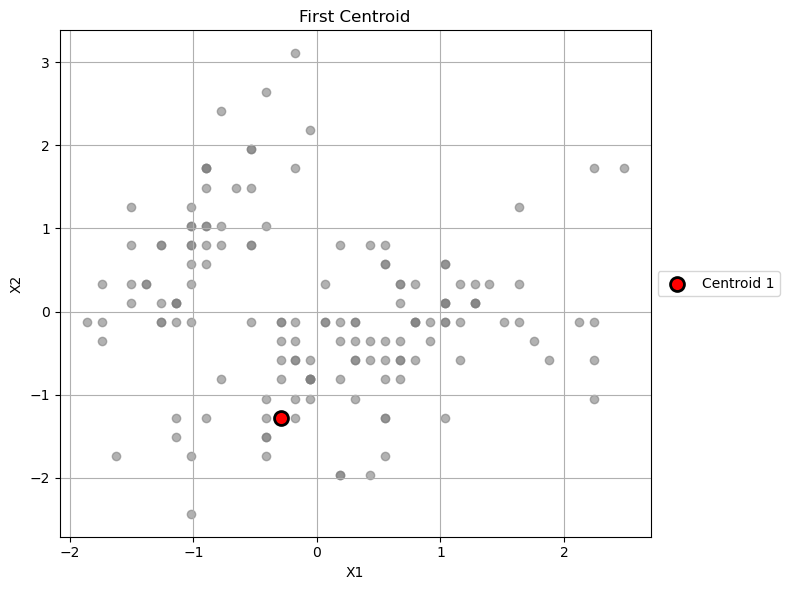

First Centroid
Centroid 1: [x1: -0.2939, x2: -1.2777, x3: 0.0801, x4: -0.1293]
--------------------------------------------------
Next Centroid: [x1: -0.1731, x2: 3.1043, x3: -1.2801, x4: -1.0465]


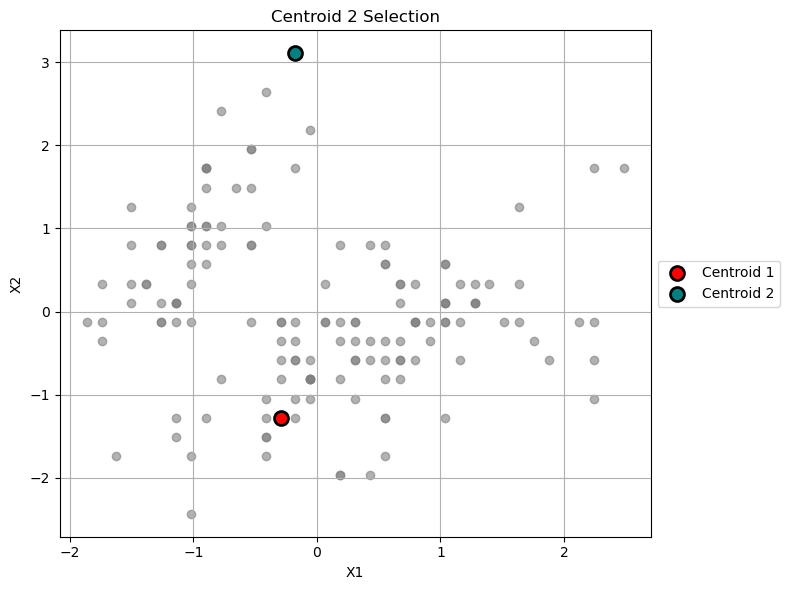

Centroid 2 Selection
Centroid 1: [x1: -0.2939, x2: -1.2777, x3: 0.0801, x4: -0.1293]
Centroid 2: [x1: -0.1731, x2: 3.1043, x3: -1.2801, x4: -1.0465]
--------------------------------------------------
Next Centroid: [x1: 2.4837, x2: 1.7205, x3: 1.4970, x4: 1.0500]


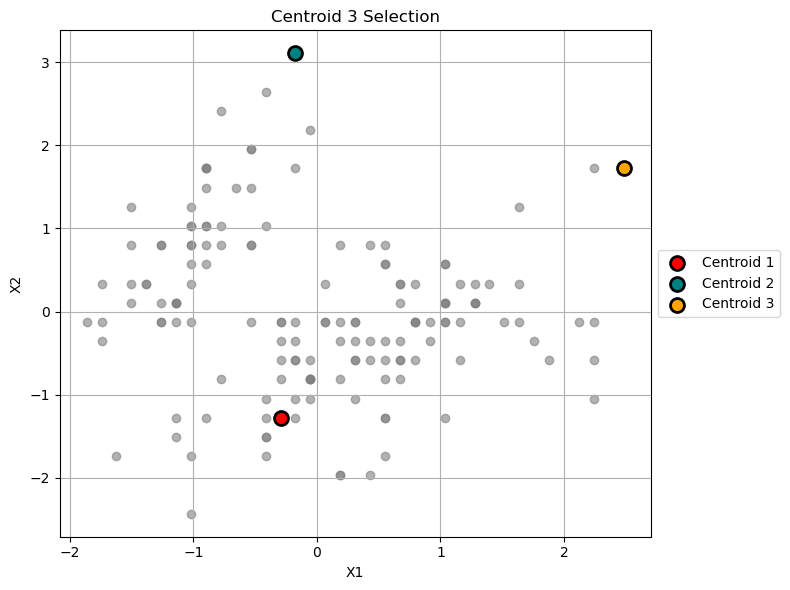

Centroid 3 Selection
Centroid 1: [x1: -0.2939, x2: -1.2777, x3: 0.0801, x4: -0.1293]
Centroid 2: [x1: -0.1731, x2: 3.1043, x3: -1.2801, x4: -1.0465]
Centroid 3: [x1: 2.4837, x2: 1.7205, x3: 1.4970, x4: 1.0500]
--------------------------------------------------
Before Iteration 1:
Number of points in cluster 1: 93
Number of points in cluster 2: 31
Number of points in cluster 3: 26
Cluster Assignments: [1 1 1 3 1 3 3 1 1 2]...
--------------------------------------------------


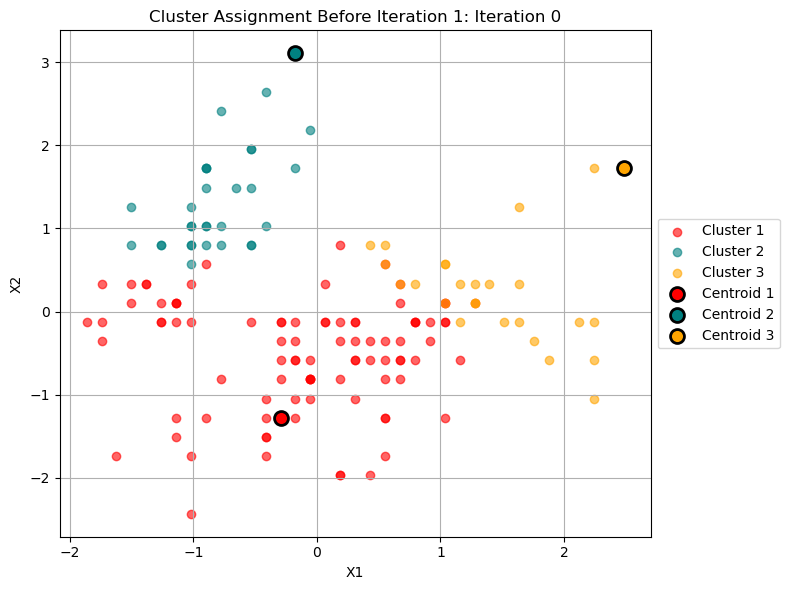

After Iteration 1:
Number of points in cluster 1: 93
Number of points in cluster 2: 31
Number of points in cluster 3: 26
Cluster Assignments: [1 1 1 3 1 3 3 1 1 2]...
--------------------------------------------------
Iteration 1 Centroids:
Centroid 1: [x1: -0.1341, x2: -0.5288, x3: 0.0959, x4: 0.0609]
Centroid 2: [x1: -0.8003, x2: 1.3560, x3: -1.2856, x4: -1.2156]
Centroid 3: [x1: 1.4340, x2: 0.2746, x3: 1.1896, x4: 1.2315]
--------------------------------------------------


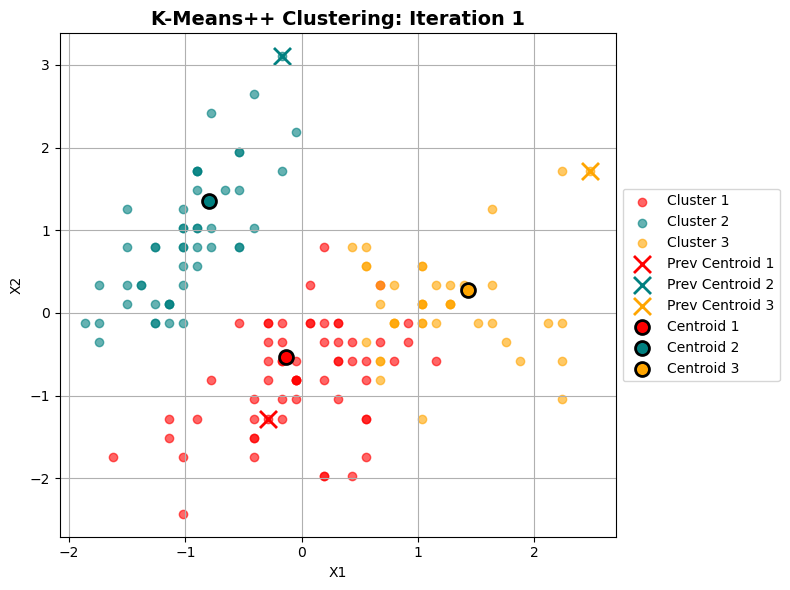

After Iteration 2:
Number of points in cluster 1: 60
Number of points in cluster 2: 49
Number of points in cluster 3: 41
Cluster Assignments: [3 3 1 3 1 3 3 2 2 2]...
--------------------------------------------------
Iteration 2 Centroids:
Centroid 1: [x1: -0.0161, x2: -0.7934, x3: 0.3333, x4: 0.2791]
Centroid 2: [x1: -0.9987, x2: 0.8921, x3: -1.2986, x4: -1.2524]
Centroid 3: [x1: 1.2172, x2: 0.0948, x3: 1.0643, x4: 1.0884]
--------------------------------------------------


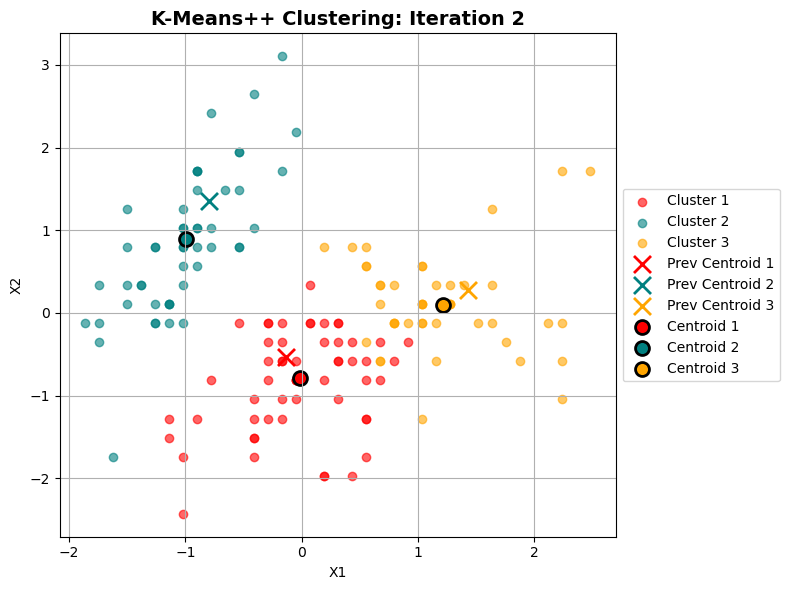

After Iteration 3:
Number of points in cluster 1: 56
Number of points in cluster 2: 50
Number of points in cluster 3: 44
Cluster Assignments: [3 3 1 3 3 3 3 2 2 2]...
--------------------------------------------------
Iteration 3 Centroids:
Centroid 1: [x1: -0.0286, x2: -0.8411, x3: 0.3655, x4: 0.3106]
Centroid 2: [x1: -1.0112, x2: 0.8395, x3: -1.3005, x4: -1.2509]
Centroid 3: [x1: 1.1855, x2: 0.1166, x3: 1.0127, x4: 1.0262]
--------------------------------------------------


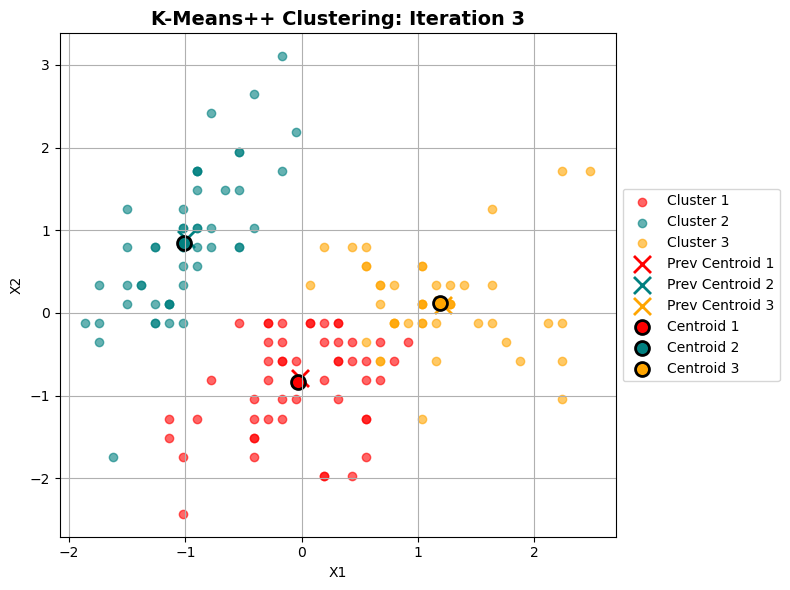

After Iteration 4:
Number of points in cluster 1: 55
Number of points in cluster 2: 50
Number of points in cluster 3: 45
Cluster Assignments: [3 3 1 3 3 3 3 2 2 2]...
--------------------------------------------------
Iteration 4 Centroids:
Centroid 1: [x1: -0.0304, x2: -0.8626, x3: 0.3614, x4: 0.3019]
Centroid 2: [x1: -1.0112, x2: 0.8395, x3: -1.3005, x4: -1.2509]
Centroid 3: [x1: 1.1607, x2: 0.1215, x3: 1.0033, x4: 1.0209]
--------------------------------------------------


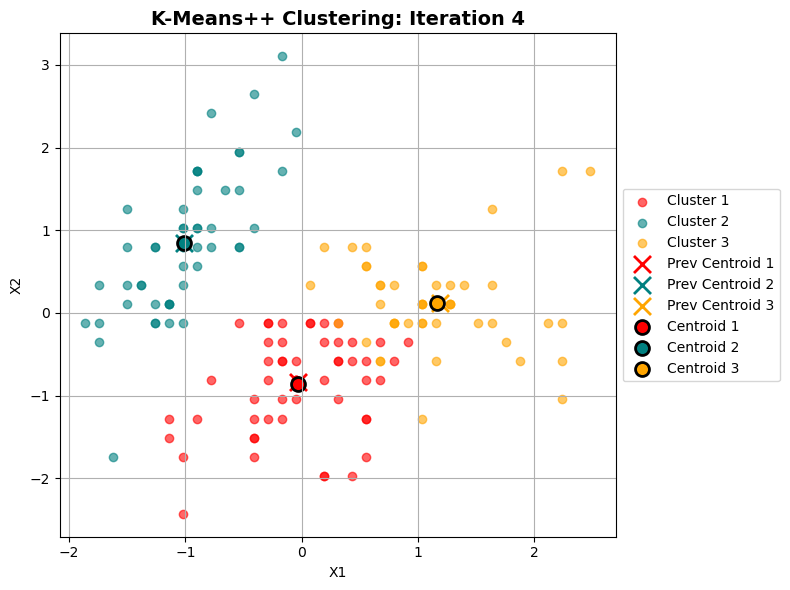

In [161]:
final_centroids, clustering_results_df = kmeans_plus_plus_with_plots(df_for_clustering_kmpp, k=3, max_iterations=4)

###  Summary 
- First Centroid: [x1: -0.2939, x2: -1.2777, x3: 0.0801, x4: -0.1293]. First centroid selected randomly from the data points. The plot for first centroid shows initial random centroid (marked as Centroid 1) placed within the dataset. The data points are in gray, and the centroid is highlighted in red.
- Second and Third Centroids: [x1: -0.1731, x2: 3.1043, x3: -1.2801, x4: -1.0465]; [x1: 2.4837, x2: 1.7205, x3: 1.4970, x4: 1.0500]. Based on farthest distance from previously selected centroid, second and third centroids are choosen. Centroid 2 is selected and marked in teal, while Centroid 3 is selected later and marked in orange.
- Next plot Cluster Assignment Before Iteration 1 shows the initial clusters formed after the selection of the centroids. The data points are colored according to their clusters. Red for Cluster 1, teal for Cluster 2, and orange for Cluster 3.
- As mentioned earliers the algorithm iteratively assigns points to the nearest centroid, then recomputes the centroids based on the new assignments. This continues until the maximum number of iterations is reached or the centroids converge.
- After Iteration 1 the centroids shift and the number of points in each cluster remains the same (93, 31, 26). The new centroids for Iteration 1 Centroids: Centroid 1: [-0.1341, -0.5288,  0.0959,  0.0609]Centroid 2: [-0.8003,  1.3560, -1.2856, -1.2156]Centroid 3: [ 1.4340,  0.2746,  1.1896,  1.2315]. Cluster assignment [1 1 1 3 1 3 3 1 1 2]... Previous centroids are marked with an 'x' symbol with its respective cluster color and the new centroids are shown with a circle/o marker
- After Iteration 2 the number of points in clusters 1, 2, and 3 changes to 60, 49, and 41 respectively, and the centroids adjust to Centroid 1: [-0.0161, -0.7934,  0.3333,  0.2791]Centroid 2: [-0.9987,  0.8921, -1.2986, -1.2524] Centroid 3: [ 1.2172,  0.0948,  1.0643,  1.0884]. Cluster assignment [3 3 1 3 1 3 3 2 2 2]... The clusters become more refined with each iteration.
- After Iteration 3 and Iteration 4, There is no change in centroid 2 and very slight change in centroid 1 and 3 which suggest that the centroids have nearly stabilized and that the clustering process is converging. The visualizations also show that the centroids are no longer moving significantly which tells that the clusters are well-formed.The final cluster assignment numbers for clusters 1,2 and 3 are 55, 50, and 45 respectively.
Iteration 3 Centroids:
    Centroid 1: [-0.0286, -0.8411,  0.3655,  0.3106]
    Centroid 2: [-1.0112,  0.8395, -1.3005, -1.2509]
    Centroid 3: [ 1.1855,  0.1166,  1.0127,  1.0262]
Iteration 4 Centroids:
    Centroid 1: [-0.0304, -0.8626,  0.3614,  0.3019]
    Centroid 2: [-1.0112,  0.8395, -1.3005, -1.2509]
    Centroid 3: [ 1.1607,  0.1215,  1.0033,  1.0209] 

In [164]:
print(clustering_results_df)

           X1        X2        X3        X4  Cluster
0    1.034539 -0.124540  0.703536  0.656917        3
1    0.551486 -0.355171  1.043591  0.787951        3
2   -0.293857 -0.124540  0.420157  0.394849        1
3    2.121409 -0.124540  1.610349  1.181053        3
4    0.189196  0.797981  0.420157  0.525883        3
..        ...       ...       ...       ...      ...
145 -0.535384  1.951133 -1.393470 -1.046525        2
146 -0.656147  1.489872 -1.280118 -1.308593        2
147  0.309959 -1.047062  1.043591  0.263815        1
148 -0.173094  1.720502 -1.166767 -1.177559        2
149 -0.535384  0.797981 -1.166767 -1.308593        2

[150 rows x 5 columns]


### Comparision between K-means and K-means ++
K-Means is a unsupervised machine learning algorithm of clustering, whose goal is to partition all data points into k clusters based on their distance from a randomly initialized centroid. K-Means++ is a modification of the basic K-Means algorithm, with major enhancements in the selection process of initial centroids. The difference only comes in at the step used for initialization. K-Means++ is actually a modification in order to enhance the efficiency and performance of the K-Means algorithm.
- Initialization
  - Kmeans: Randomly selects initial centroids which results in suboptimal cluster formation (as seen in the larger variance in cluster sizes).
  - Kmeans++: Chooses initial centroids based on k values in such a way that centroids are spread-out manner which typically lead to faster convergence and better clustering.
- Cluster Assignments:
  - K-Means: The clusters remain uneven, with one cluster containing as many as 70 points, and others with fewer points (49, 31), reflecting the influence of random initialization.
  - K-Means++: The cluster assignments are more balanced after iteration 2 (60, 49, 41), which indicates better separation   of the data points.
- Centroid Movements:
   - K-Means: Centroids take longer to stabilize and move more in earlier iterations.
  - K-Means++: Centroids stabilized faster and they are closer to their final positions after fewer iterations.
- Performance
  - Kmeans: It can lead to poor clustering depending upon random initialization.
  - Kmeans++: Clustering results are better also more consistent clustering results.
- Speed
  - Kmeans: Takes longer to converge but faster during initialization.
  - Kmeans++: Converges faster but bit slow during initialization. 
  
Generally speaking, K-Means++ is preferred because it offers better initialization, which in turn means faster convergence and more accurate clustering results. This avoids the problem of falling into a local optimum and stays away from the situation where the clusters are imbalanced or poorly defined.

### PART 3: Implementation of KNN

### Importing dataset

In [169]:
df = pd.read_csv('cluster_data2.csv')
df.head()

,X1,X2,X3,X4
0,5.21,3.65,1.42,0.25
1,5.07,3.41,1.43,0.19
2,5.85,2.65,4.14,1.27
3,5.64,2.73,4.03,1.23
4,6.55,2.90,5.54,2.05


### Checking the rows of the dataset

In [172]:
lengt = len(df)
print(f"Length of dataset: {lengt}")

Length of dataset: 15


### Checking the distribution and characteristics of the dataset it gives an overview of the key metrics of numerical columns in the dataset.

In [175]:
df.describe()

,X1,X2,X3,X4
count,15.000000,15.000000,15.000000,15.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.691165,0.295074,1.771032,0.761923
min,4.860000,2.650000,1.420000,0.190000
25%,5.140000,2.860000,1.510000,0.280000
50%,5.850000,2.960000,4.270000,1.340000
75%,6.500000,3.320000,5.415000,1.935000
max,6.740000,3.650000,5.770000,2.170000


#### Each variable contains 15 values.
- X1 average is about 5.84 with a moderate spread of values around average ranging from 4.86 to 6.74.
- X2 displays smaller spread having an average of 3.05 and values are ranging from 2.65 to 3.65 which tells that it varies the least among the four.
- X3 shows the most variation in values ranging from 1.42 to 5.77 and an average of 3.76.
- X4 has moderate variability, with values ranging from 0.19 to 2.17 and an average of 1.20.
- X3 has the greatest range of values when compared to other features. 
- So, Using Z-score standardization (or normalization) can benefit given the variability in data. 
- Z-score Standardization formula = X - Mean / Standard Deviation and scale is [-3,3]

In [178]:
def z_score_standardize(df):
    for column in df.columns:
        mean_val = df[column].mean()
        std_dev = df[column].std()
        df[column] = (df[column] - mean_val) / std_dev
    return df
df_knn_standardized = z_score_standardize(df)

In [180]:
df_knn_standardized.describe()

,X1,X2,X3,X4
count,1.500000e+01,1.500000e+01,1.500000e+01,1.500000e+01
mean,1.095420e-15,5.625130e-16,-1.739349e-16,-7.401487e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.422718e+00,-1.369149e+00,-1.320510e+00,-1.323843e+00
25%,-1.017605e+00,-6.574626e-01,-1.269693e+00,-1.205721e+00
50%,9.645545e-03,-3.185643e-01,2.887205e-01,1.854956e-01
75%,9.500862e-01,9.014693e-01,9.352361e-01,9.664144e-01
max,1.297326e+00,2.019833e+00,1.135684e+00,1.274844e+00


As seen above the data has been standardized where mean to 0 and standard deviation to 1

In [183]:
df_standard_knn = df_knn_standardized.copy()
df_standard_knn.head()

,X1,X2,X3,X4
0,-0.916327,2.019833,-1.320510,-1.245095
1,-1.118883,1.206478,-1.314864,-1.323843
2,0.009646,-1.369149,0.215317,0.093623
3,-0.294189,-1.098030,0.153206,0.041124
4,1.022428,-0.521903,1.005816,1.117348


In [185]:
clustering_results_df.head()

,X1,X2,X3,X4,Cluster
0,1.034539,-0.124540,0.703536,0.656917,3
1,0.551486,-0.355171,1.043591,0.787951,3
2,-0.293857,-0.124540,0.420157,0.394849,1
3,2.121409,-0.124540,1.610349,1.181053,3
4,0.189196,0.797981,0.420157,0.525883,3


### Using problem 2 for training which contains original data points and cluster labels

In [188]:
train_data = clustering_results_df[['X1', 'X2', 'X3', 'X4']].to_numpy()
train_labels = clustering_results_df['Cluster'].to_numpy()

#### Here I'am preparing the features and labels from the clustering results of Part 2 (k-means++) for KNN. The train_data will be the input features and train_labels will be the target labels (clusters) for KNN . We will use this to classify new data points (cluster2.csv) based on their nearest neighbors (k=3) in the feature space.

### Step-1: Select the number K of the neighbors

In [192]:
k = 3

#### Setting the number of neighbors to 3. Now, it will consider the 3 closest data points in the feature space to determine the class of a new point.

In [195]:
df_standard_knn

,X1,X2,X3,X4
0,-0.916327,2.019833,-1.320510,-1.245095
1,-1.118883,1.206478,-1.314864,-1.323843
2,0.009646,-1.369149,0.215317,0.093623
3,-0.294189,-1.098030,0.153206,0.041124
4,1.022428,-0.521903,1.005816,1.117348
5,-0.019291,-1.030251,0.288721,0.185496
6,-1.422718,0.867579,-1.303571,-1.284469
7,1.138174,-0.318564,0.983231,0.959852
8,-1.205693,1.138698,-1.247107,-1.218846
9,0.877745,-0.081336,0.887242,1.274844


### Using df_standard_knn standardized dataset for for testing

In [198]:
test_data = df_standard_knn[['X1', 'X2', 'X3', 'X4']].to_numpy()

#### Here I'm converting the test features dataframe to numpy array which will be used during prediction

### Step-2: Calculate the Euclidean distance of K number of neighbors

In [202]:
def euclid_distance(a1, a2):
    return np.sqrt(np.sum((a1 - a2) ** 2))

#### Calculating the Euclidean distance between two points, a1 and a2 which is the distance between new data point by and all the points in the training set.

### Step-3: Take the K nearest neighbors as per the calculated Euclidean distance.

In [206]:
def knn_euclid(train_data, train_labels, query_point, k):
    distances = []
    for i in range(len(train_data)):
        distance = euclid_distance(train_data[i], query_point)
        distances.append((distance, train_labels[i]))
    distances.sort(key=lambda x: x[0])
    nearest_neighbors = distances[:k]
    return nearest_neighbors


#### Here I'm using Euclidean distance to find the k nearest neighbors of a given query point (test data). It will return the k nearest neighbors to the query point which will be used to predict the class/cluster of the query point.

### Step-4: Among these k neighbors, count the number of the data points in each category.

In [210]:
def count_data_pt(neighbors):
    cls_votes = {}
    for _, label in neighbors:
        if label in cls_votes:
            cls_votes[label] += 1
        else:
            cls_votes[label] = 1
    return cls_votes

#### Function will counts the occurrences of each label among the k =3 nearest neighbors.

### Step-5: Assign the new data points to that category for which the number of the neighbor is maximum.

In [214]:
def assign_class(class_votes):
    return max(class_votes, key=class_votes.get)

#### This function will help in assigning a class (cluster) to the query point based on the votes from the nearest neighbors k=3.

### Full K-NN classification process

In [218]:
def knn_classification(train_data, train_labels, test_data, k=3):
    predictions = []
    for query_point in test_data:
        neighbors = knn_euclid(train_data, train_labels, query_point, k)
        class_votes = count_data_pt(neighbors)
        predicted_class = assign_class(class_votes)
        predictions.append(predicted_class)
    return np.array(predictions)

#### Merging all the above methods in final method which performs K-Nearest Neighbors classification on a set of test data points, using the training data and labels.This function will return the predicted class labels for the test data points.

### Perform K-NN classification and print the predicted class cluster

### Please assign class for each data point based on the result of problem #2 using K-NN method.

In [223]:
predicted_labels = knn_classification(train_data, train_labels, test_data, k)
df_standard_knn['Predicted_Class'] = predicted_labels
print(df_standard_knn)

          X1        X2        X3        X4  Predicted_Class
0  -0.916327  2.019833 -1.320510 -1.245095                2
1  -1.118883  1.206478 -1.314864 -1.323843                2
2   0.009646 -1.369149  0.215317  0.093623                1
3  -0.294189 -1.098030  0.153206  0.041124                1
4   1.022428 -0.521903  1.005816  1.117348                3
5  -0.019291 -1.030251  0.288721  0.185496                1
6  -1.422718  0.867579 -1.303571 -1.284469                2
7   1.138174 -0.318564  0.983231  0.959852                3
8  -1.205693  1.138698 -1.247107 -1.218846                2
9   0.877745 -0.081336  0.887242  1.274844                3
10  0.371353 -0.623573  0.345185  0.237994                1
11  1.297326 -0.047446  1.050988  0.972977                3
12 -1.393781  0.935359 -1.292278 -1.192596                2
13  1.051364 -0.386344  1.135684  1.104224                3
14  0.602847 -0.691352  0.412942  0.277368                1


#### KNN classification has been successfully applied and the predicted class/clusters have been updated to the dataframe column Predicted_Class. Each row is the test point along it's predicted class label.
- Data points 0, 1, 6, 8, and 12 are classified as Class 2.
- Data points 2, 3, 5, 10, and 14 are classified as Class 1.
- Data points 4, 7, 9, 11, and 13 are classified as Class 3.

### Plotting clusters, centroids and K-NN classified points

In [227]:
def plot_knn_with_kmeans(train_data, train_labels, centroids, test_data, predicted_labels):
    plt.figure(figsize=(8, 6))
    colors = ['r', '#008080', '#FFA500']
    train_labels = train_labels - 1 if train_labels.min() == 1 else train_labels
    predicted_labels = predicted_labels - 1 if predicted_labels.min() == 1 else predicted_labels
    for cluster_idx in np.unique(train_labels):
        cluster_points = train_data[train_labels == cluster_idx]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=colors[cluster_idx], alpha=0.5, label=f'K-Means++ Cluster {cluster_idx + 1}', marker='o')
    for i, centroid in enumerate(centroids):
        plt.scatter(centroid[0], centroid[1], color=colors[i], marker='x', s=150, linewidth=2, label=f'Centroid {i + 1}')
    for cluster_idx in np.unique(predicted_labels):
        knn_points = test_data[predicted_labels == cluster_idx]
        plt.scatter(knn_points[:, 0], knn_points[:, 1], color=colors[cluster_idx], edgecolor='black', linewidth=0.5, label=f'K-NN Cluster {cluster_idx + 1}', alpha=0.8, marker='s', s=50)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title('K-NN Classification Results on K-Means++ Clusters')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### This plot of knn with k-means ++ will help in visualizing how the KNN classification aligns with the clusters created by K-Means++. It tells how well the test data is classified into the existing clusters.

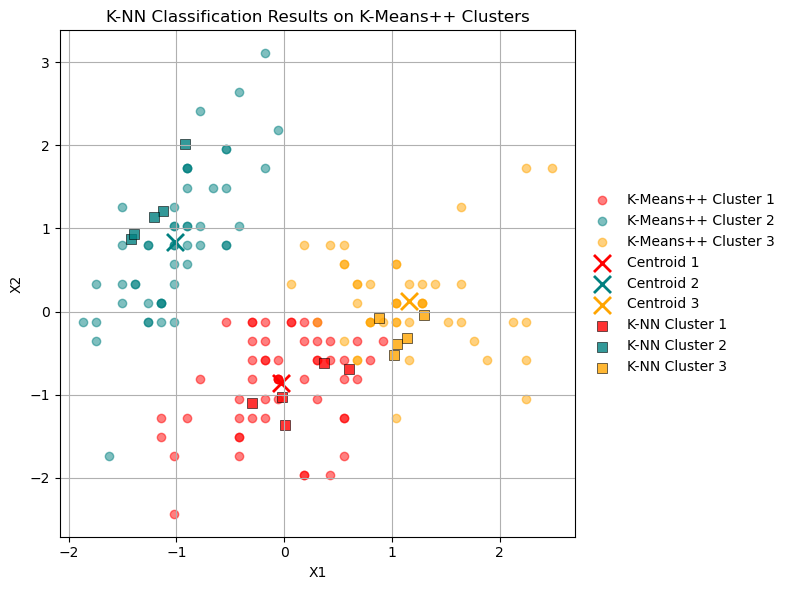

In [230]:
plot_knn_with_kmeans(train_data, train_labels, final_centroids, test_data, predicted_labels)

#### This plot displays a clear differentiation between the clusters of K-Means++ and the predictions made by the KNN which is helpful in visualizing how test points fall with respect to the centroids of K-Means++.
Here K-Means++ Clusters Cluster 1 (red circles), Cluster 2 (teal circles), Cluster 3 (orange circles)
Centroids: Shown as X markers which is the the center of the clusters formed by the K-Means++ algorithm.Centroid 1 (red X),Centroid 2(teal X), Centroid 3 (orange X). KNN Predicted Clusters are shown in square markers K-NN Cluster 1 (red squares), K-NN Cluster 2 (teal squares) and K-NN Cluster 3 (orange squares)

### KNN is a supervised classification algorithm. It helps in assigning labels to new data points based on the majority label of their k-nearest neighbors in the training set(in our case k=3).It uses distance metrics like Euclidean to calculate the proximity to neighboring data points.
- Here the KNN results predicts three distinct classes/clusters (1, 2, and 3) for the test data points.Predicted classes seem to align pretty well with the clusters
- There are many advantages of KNN: it is Non-parametric, meaning there are no assumptions about the data distribution and it's simple and intuitive.
- KNN has disadvantages such as: sensitive to the choice of k (number of neighbors) and distance metric. And can be computationally expensive for large datasets to make a prediction because the distances need to be computed for each data point.

### KNN vs. K-Means/K-Means++:
- Its like Clustering vs. Classification i.e. K-Means and K-Means++ are unsupervised clustering algorithms since they group the unlabelled data into clusters depending on the similarity. While on the other side, KNN is a supervised classification technique in which labels are provided to new points depending on the labelled distance near it.
- K-Means/K-Means++ is utilised when we don't know our data's labels and intend to find natural clusterings. On the other hand, KNN will be used in conditions where you have labelled training data i.e. part 2 results clustering labels which we want to classify on new unseen data points i.e. cluster2.csv.
- K-Means++ returns balanced data clusters, whereas KNN sends detailed predictions for each test point using information from the training data. Those labels of the test points will be either 1, 2, or 3, depending on how close to the three clusters generated by K-Means++.